In [1]:
import os
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from modules.clustering_utils import load_signatures, find_optimal_clusters, plot_results

In [2]:
signatures_path = os.path.join("data", "a")
if not os.path.exists(signatures_path):
    raise FileNotFoundError(f"The directory {signatures_path} does not exist.")

min_n_time_points = math.inf
min_value = math.inf
max_value = -math.inf

# Identify the minimum number of time points across all files
for file in os.listdir(signatures_path):
    if not file.endswith(".npy"):
        continue

    np_file = np.load(os.path.join(signatures_path, file))
    n_time_points, n_doppler_bins = np_file.shape
    min_n_time_points = min(min_n_time_points, n_time_points)
    min_value = min(min_value, np.min(np_file))
    max_value = max(max_value, np.max(np_file))

print(f"The minimum number of time points across all files is: {min_n_time_points}")
print(f"Value range across all files: [{min_value:.3f}, {max_value:.3f}]")

The minimum number of time points across all files is: 409
Value range across all files: [0.000, 1.000]


In [3]:
def analyze_with_pca(signatures_path, min_n_time_points):
    signatures, filenames = load_signatures(signatures_path, min_n_time_points)
    
    n_samples = len(signatures)
    signatures_reshaped = signatures.reshape(n_samples, -1)
    
    pca = PCA(n_components=0.95)
    signatures_pca = pca.fit_transform(signatures_reshaped)
    
    optimal_clusters, silhouette_scores = find_optimal_clusters(signatures_pca)
    
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(signatures_pca)
    
    plot_results(signatures_pca[:, :2], cluster_labels, silhouette_scores, "PCA")
    
    print(f"Number of PCA components retained: {signatures_pca.shape[1]}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.3f}")
    
    return cluster_labels, filenames, optimal_clusters

In [4]:
def compute_2dpca(X, n_components):
    n_samples = len(X)
    mean_image = np.mean(X, axis=0)
    
    G = np.zeros((X.shape[2], X.shape[2]))
    for i in range(n_samples):
        diff = X[i] - mean_image
        G += np.dot(diff.T, diff)
    G /= n_samples
    
    eigenvalues, eigenvectors = np.linalg.eigh(G)
    idx = eigenvalues.argsort()[::-1]
    eigenvectors = eigenvectors[:, idx]
    
    return eigenvectors[:, :n_components]

def analyze_with_2dpca(signatures_path, min_n_time_points):
    signatures, filenames = load_signatures(signatures_path, min_n_time_points)
    
    n_components = 10  # Number of principal components to keep
    projection_matrix = compute_2dpca(signatures, n_components)
    
    projected_signatures = np.array([np.dot(sig, projection_matrix) 
                                   for sig in signatures])
    
    n_samples = len(projected_signatures)
    features = projected_signatures.reshape(n_samples, -1)
    
    optimal_clusters, silhouette_scores = find_optimal_clusters(features)
    
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    
    features_2d = features[:, :2]
    plot_results(features_2d, cluster_labels, silhouette_scores, "2DPCA")
    
    return cluster_labels, filenames, optimal_clusters


Analyzing with PCA method:


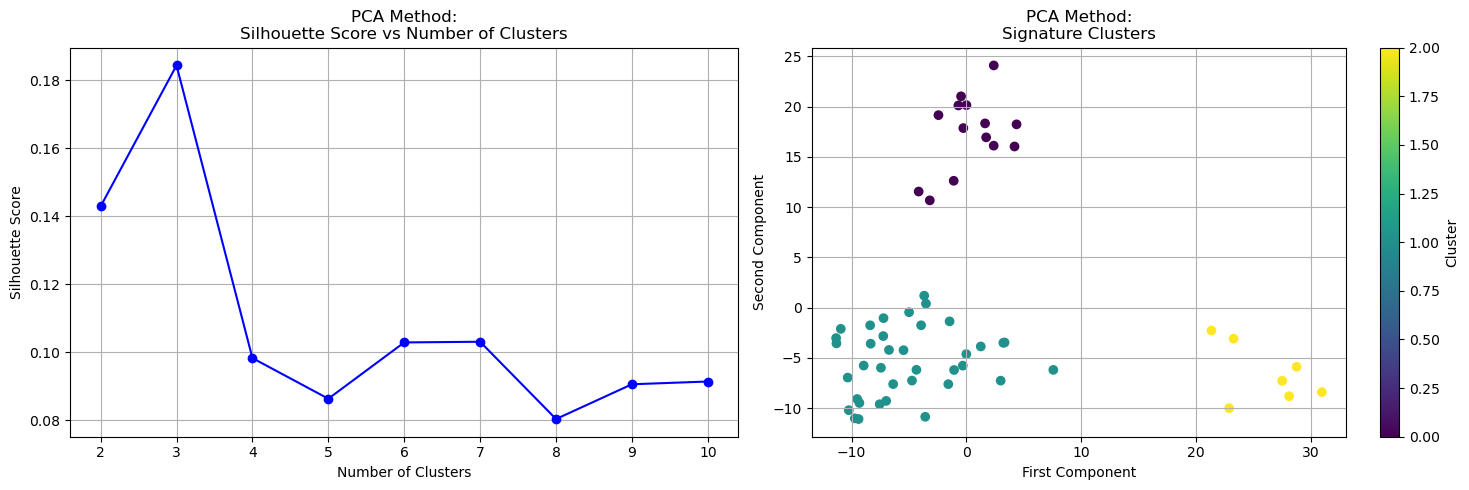

Number of PCA components retained: 46
Total explained variance: 0.955
Number of clusters found: 3

Analyzing with 2DPCA method:


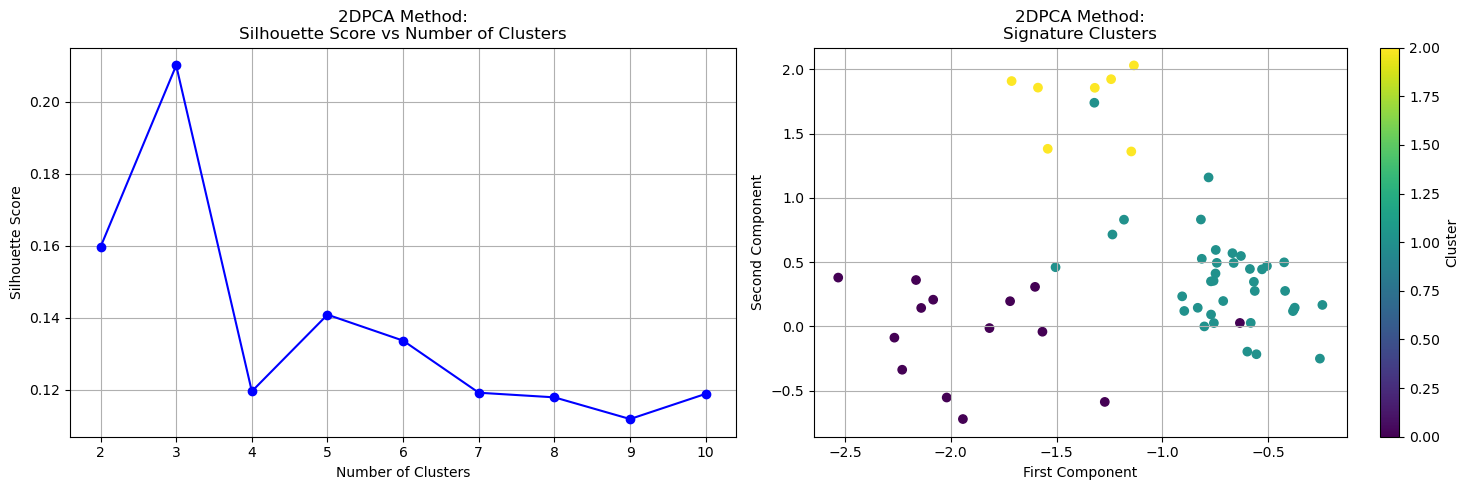

Number of clusters found: 3


In [5]:
# Run all methods and collect results
results = {}

methods = {
    'PCA': analyze_with_pca,
    '2DPCA': analyze_with_2dpca,
}

for method_name, method_func in methods.items():
    print(f"\nAnalyzing with {method_name} method:")
    labels, files, n_clusters = method_func(signatures_path, min_n_time_points)
    results[method_name] = {
        'labels': labels,
        'n_clusters': n_clusters,
        'files': files
    }
    print(f"Number of clusters found: {n_clusters}")